# ****Monte Carlo Simulation of the 2022 FIFA World Cup****
![World Cup](https://images.unsplash.com/photo-1637203727700-9d86c74904d6?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1470&q=80)

In [84]:
'''Installing Libraries''' 
#!pip install handcalcs
#!pip install pydot
import numpy as np 
import pandas as pd 
import lxml
from os import system
import subprocess
import random, copy
import math
import datetime
import requests
import csv
import bs4
from bs4 import BeautifulSoup
from datetime import date
from itertools import combinations
from functools import reduce
import warnings
from scipy.stats import rankdata
import handcalcs.render
warnings.filterwarnings("ignore")

In [33]:
'''International Matches'''
url = 'https://raw.githubusercontent.com/martj42/international_results/master/results.csv'
url_elos = 'https://www.fifa.com/fifa-world-ranking/men?dateId=id13792'
r = requests.get(url)

'''Functions for saving and opening the fetched html
def save_html(html, path):
    with open(path, 'wb') as f:
        f.write(html)
        
        
save_html(r.content, 'fifaresults')
def open_html(path):
    with open(path, 'rb') as f:
        return f.read()

    
html = open_html('fifaresults')'''
''''''''''''''''''''''''''''''''''''''''''
soup = BeautifulSoup(r.content, 'lxml')

first = str(soup.select_one('p')).split('\n')
results = [first[i].split(',') for i in range(len(first))]
results = results[:-1]
'''Creating DataFrame of International Match Results'''

all_results = [[],[],[], [], [], [], [], [],[]]
for i in range(len(results)):    
    date = results[i][0]   
    home_team = results[i][1]
    away_team = results[i][2]
    home_score = results[i][3]
    away_score = results[i][4]
    tournament = results[i][5]
    city = results[i][6]
    country = results[i][7]
    neutral = results[i][8]  
    all_results[0].append(date)
    all_results[1].append(home_team)
    all_results[2].append(away_team)
    all_results[3].append(home_score)
    all_results[4].append(away_score)
    all_results[5].append(tournament)
    all_results[6].append(city)
    all_results[7].append(country)
    all_results[8].append(neutral)
    
col = results[0]
col[0] = 'date'
data = []
for i in range(len(results)):
    datacols = [all_results[0][i], all_results[1][i], all_results[2][i], all_results[3][i], all_results[4][i], all_results[5][i], all_results[6][i], all_results[7][i],all_results[8][i]] 
    data.append(datacols)
masterdata = pd.DataFrame(data, columns = results[0])

In [34]:
masterdata.drop(0, inplace = True)
masterdata = masterdata[:44158] #index of the last result before world cup
winmask = masterdata.home_score.astype(int) > masterdata.away_score.astype(int)
losemask = masterdata.home_score.astype(int) < masterdata.away_score.astype(int)
drawmask = masterdata.home_score.astype(int) - masterdata.away_score.astype(int) == 0
homemask = masterdata.home_team.astype(str) == masterdata.country.astype(str)
neutralmask = masterdata.home_team.astype(str) != masterdata.country.astype(str)
masterdata.insert(0, 'country_full', masterdata.home_team)
masterdata

,country_full,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
1,Scotland,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,FALSE
2,England,1873-03-08,England,Scotland,4,2,Friendly,London,England,FALSE
3,Scotland,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,FALSE
4,England,1875-03-06,England,Scotland,2,2,Friendly,London,England,FALSE
5,Scotland,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,FALSE
...,...,...,...,...,...,...,...,...,...,...
44154,Costa Rica,2022-09-27,Costa Rica,Uzbekistan,2,1,Friendly,Suwon,South Korea,TRUE
44155,Ecuador,2022-09-27,Ecuador,Japan,0,0,Kirin Challenge Cup,Düsseldorf,Germany,TRUE
44156,Egypt,2022-09-27,Egypt,Liberia,3,0,Friendly,Alexandria,Egypt,FALSE
44157,Equatorial Guinea,2022-09-27,Equatorial Guinea,Togo,2,2,Friendly,Casablanca,Morocco,TRUE


The data consists of a total of 44158 match results. The first match available is Scotland's 0-0 draw vs England in 1872. There are a total of 

In [35]:
masterdata.describe()

,country_full,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
count,44158,44158,44158,44158,44158,44158,44158,44158,44158,44158
unique,311,15502,311,306,26,22,140,2006,267,2
top,Brazil,2012-02-29,Brazil,Uruguay,1,0,Friendly,Kuala Lumpur,United States,FALSE
freq,591,66,591,558,13069,16454,17402,675,1257,33228


In [36]:
masterdata.isna().sum()

country_full    0
date            0
home_team       0
away_team       0
home_score      0
away_score      0
tournament      0
city            0
country         0
neutral         0
dtype: int64

There are a total of 311 nations represented in the dataset, based on the unique countries and home teams.  

In [37]:
print('Total teams:', len(masterdata.country_full.unique()))
print('Home teams:', len(masterdata.home_team.unique()))
print('Away teams:', len(masterdata.away_team.unique()))

Total teams: 311
Home teams: 311
Away teams: 306


In [40]:
'''FIFA Coca Cola World Rankings'''
fifa_rankings = pd.read_csv('fifa_ranking-2022-10-06.csv')
fifa_rankings = fifa_rankings.set_index('rank_date')
fifa_rankings.index = pd.to_datetime(fifa_rankings.index)
fifa_rankings = fifa_rankings[fifa_rankings.index == '2022-10-06'].sort_values(by = 'country_full', ascending = True)
fifa_rankings['country_full'] = np.where((fifa_rankings.country_full == 'USA'), 'United States', fifa_rankings.country_full)
fifa_rankings['country_full'] = np.where((fifa_rankings.country_full == 'IR Iran'), 'Iran', fifa_rankings.country_full)
fifa_rankings['country_full'] = np.where((fifa_rankings.country_full == 'Korea Republic'), 'South Korea', fifa_rankings.country_full)
fifa_rankings.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation
rank_date,,,,,,,
2022-10-06,156,Afghanistan,AFG,1023.04,1023.04,2,AFC
2022-10-06,66,Albania,ALB,1354.11,1361.81,0,UEFA
2022-10-06,37,Algeria,ALG,1489.10,1480.59,-4,CAF
2022-10-06,188,American Samoa,ASA,900.27,900.27,0,OFC
2022-10-06,151,Andorra,AND,1035.20,1028.70,-1,UEFA


In [41]:
len(fifa_rankings.country_full.unique())

211

In [42]:
masterdata['Result']=0    
wins = masterdata[winmask][['Result']]
wins.Result = 2
losses = masterdata[losemask][['Result']]
losses.Result = 0
draws = masterdata[drawmask][['Result']]
draws.Result = 0
home_away = masterdata[homemask][['neutral']]
home_away.neutral = 0
neutral = masterdata[neutralmask][['neutral']]
neutral.neutral = 1
for i in wins.index:
    masterdata.loc[i,'Result']= 2
for i in losses.index:
    masterdata.loc[i,'Result']= 0
for i in draws.index:
    masterdata.loc[i,'Result']= 1
for i in home_away.index:
    masterdata.loc[i,'neutral']= 0
for i in neutral.index:
    masterdata.loc[i,'neutral']= 1
masterdata.home_score.astype(int) - masterdata.away_score.astype(int)
masterdata = masterdata.set_index('date')
masterdata['goal_fraction'] = masterdata.home_score.astype(int) /( masterdata.home_score.astype(int) + masterdata.away_score.astype(int))
masterdata['concat']=masterdata.home_team + masterdata.away_team
masterdata['concat_home']=masterdata.home_team + masterdata.away_team + masterdata.Result.astype(str)
masterdata['concat_away']=masterdata.away_team + masterdata.home_team + masterdata.Result.astype(str)
masterdata.fillna(0, inplace = True)
'''Removing friendly Matches, select only matches from 2000 onwards and include only matches featuring the teams in top 61(Ghana is ranked #61, lowest ranked team)'''
masterdata = masterdata[masterdata.tournament != 'Friendly']
masterdata = masterdata[masterdata.index > "2000"]
masterdata  = masterdata.assign(home_score = lambda masterdata: masterdata.home_score.astype(int))
masterdata  = masterdata.assign(away_score = lambda masterdata: masterdata.away_score.astype(int))
masterdata = masterdata[masterdata.home_score <10]
masterdata = masterdata[masterdata.away_score <10]
top61 = fifa_rankings.sort_values(by = 'rank').head(61).country_full.values
masterdata = masterdata[masterdata.home_team.isin(top61)]
masterdata = masterdata[masterdata.away_team.isin(top61)]
masterdata

,country_full,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Result,goal_fraction,concat,concat_home,concat_away
date,,,,,,,,,,,,,,
2000-01-22,Ghana,Ghana,Cameroon,1,1,African Cup of Nations,Accra,Ghana,0,1,0.500000,GhanaCameroon,GhanaCameroon1,CameroonGhana1
2000-01-23,Nigeria,Nigeria,Tunisia,4,2,African Cup of Nations,Lagos,Nigeria,0,2,0.666667,NigeriaTunisia,NigeriaTunisia2,TunisiaNigeria2
2000-01-25,Burkina Faso,Burkina Faso,Senegal,1,3,African Cup of Nations,Kano,Nigeria,1,0,0.250000,Burkina FasoSenegal,Burkina FasoSenegal0,SenegalBurkina Faso0
2000-01-28,Egypt,Egypt,Senegal,1,0,African Cup of Nations,Kano,Nigeria,1,2,1.000000,EgyptSenegal,EgyptSenegal2,SenegalEgypt2
2000-01-29,Tunisia,Tunisia,Morocco,0,0,African Cup of Nations,Lagos,Nigeria,1,1,0.000000,TunisiaMorocco,TunisiaMorocco1,MoroccoTunisia1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-25,Netherlands,Netherlands,Belgium,1,0,UEFA Nations League,Amsterdam,Netherlands,0,2,1.000000,NetherlandsBelgium,NetherlandsBelgium2,BelgiumNetherlands2
2022-09-26,England,England,Germany,3,3,UEFA Nations League,London,England,0,1,0.500000,EnglandGermany,EnglandGermany1,GermanyEngland1
2022-09-26,Hungary,Hungary,Italy,0,2,UEFA Nations League,Budapest,Hungary,0,0,0.000000,HungaryItaly,HungaryItaly0,ItalyHungary0


In [43]:
masterdata[masterdata.columns[1:]]

,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Result,goal_fraction,concat,concat_home,concat_away
date,,,,,,,,,,,,,
2000-01-22,Ghana,Cameroon,1,1,African Cup of Nations,Accra,Ghana,0,1,0.500000,GhanaCameroon,GhanaCameroon1,CameroonGhana1
2000-01-23,Nigeria,Tunisia,4,2,African Cup of Nations,Lagos,Nigeria,0,2,0.666667,NigeriaTunisia,NigeriaTunisia2,TunisiaNigeria2
2000-01-25,Burkina Faso,Senegal,1,3,African Cup of Nations,Kano,Nigeria,1,0,0.250000,Burkina FasoSenegal,Burkina FasoSenegal0,SenegalBurkina Faso0
2000-01-28,Egypt,Senegal,1,0,African Cup of Nations,Kano,Nigeria,1,2,1.000000,EgyptSenegal,EgyptSenegal2,SenegalEgypt2
2000-01-29,Tunisia,Morocco,0,0,African Cup of Nations,Lagos,Nigeria,1,1,0.000000,TunisiaMorocco,TunisiaMorocco1,MoroccoTunisia1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-25,Netherlands,Belgium,1,0,UEFA Nations League,Amsterdam,Netherlands,0,2,1.000000,NetherlandsBelgium,NetherlandsBelgium2,BelgiumNetherlands2
2022-09-26,England,Germany,3,3,UEFA Nations League,London,England,0,1,0.500000,EnglandGermany,EnglandGermany1,GermanyEngland1
2022-09-26,Hungary,Italy,0,2,UEFA Nations League,Budapest,Hungary,0,0,0.000000,HungaryItaly,HungaryItaly0,ItalyHungary0


In [44]:
GroupA = ['Senegal', 'Netherlands', 'Qatar', 'Ecuador']
GroupB = ['England', 'Iran', 'Wales', 'United States']
GroupC = ['Argentina', 'Mexico', 'Saudi Arabia', 'Poland']
GroupD = ['France', 'Australia', 'Denmark', 'Tunisia']
GroupE = ['Spain', 'Costa Rica', 'Germany', 'Japan']
GroupF = ['Belgium', 'Canada', 'Morocco', 'Croatia']
GroupG = ['Brazil', 'Serbia', 'Switzerland', 'Cameroon']
GroupH = ['Portugal', 'Ghana', 'Uruguay', 'South Korea']
allteams = GroupA+GroupB+GroupC+GroupD+GroupE+GroupF+GroupG+GroupH
allteams = pd.DataFrame(allteams)
allteams['Elo']=0
for i in allteams.index:
    allteams['Elo'] = np.where((allteams[0] == allteams.iloc[i][0]), int(float(fifa_rankings[fifa_rankings.country_full == allteams.iloc[i][0]].total_points[0])), allteams.Elo)
wcteams = allteams[allteams.columns[0]].values

In [45]:
import handcalcs.render

In [47]:
%%render
h2hweight = 0 #weight of head-to-head matchups on incrementing probabilities
Wp1 = 0.75 #win probability of Team A
Wp2 = 1-Wp1 #win probability of Team B
h2h_p1 = 2/3 #fraction of H2H results Team A
h2h_p2 = 1-h2h_p1 #H2H results fraction Team B
p1_undershoot = (1-h2hweight)*Wp1 + (h2hweight * h2h_p1 * Wp1) #Team A undershoot
p2_undershoot = (1-h2hweight)*Wp2 + (h2hweight * h2h_p2 * Wp2) #Team B undershoot
Wp1_update = ((1-p1_undershoot-p2_undershoot)*Wp1) + p1_undershoot  #Team A updated win probability
Wp2_update = ((1-p1_undershoot-p2_undershoot)*Wp2) + p2_undershoot  #Team B updated win probability

<IPython.core.display.Latex object>

In [48]:
%%render
Wp1_update = (2*h2hweight *h2h_p1*Wp1) + (h2hweight*(Wp1**2)) -(2*h2hweight *h2h_p1*(Wp1**2))+((1-h2hweight)*Wp1) #Team A win probability with general expression
Wp2_update = (2*h2hweight *h2h_p2*Wp2) + (h2hweight*(Wp2**2)) -(2*h2hweight *h2h_p2*(Wp2**2))+((1-h2hweight)*Wp2) #Team B win probability with general expression

<IPython.core.display.Latex object>

In [49]:
%%render
h2hweight = 0.3
Homeweight = 0.2
Wp1= 0.75 #win probability from elo formula team A
Wp2 = 1-Wp1 #win probability from elo formula team B
h2h_p1 = 2/3 
h2h_p2 = 1-h2h_p1
Home_p1 = 0.6  
Home_p2 = 1-Home_p1

p1_undershoot = (1-h2hweight-Homeweight)*Wp1 + (h2hweight * h2h_p1 * Wp1) + (Homeweight * Home_p1 *Wp1) #Team A undershoot
p2_undershoot = (1-h2hweight-Homeweight)*Wp2 + (h2hweight * h2h_p2 *Wp2) + (Homeweight * Home_p2 *Wp2) #Team B undershoot
Wp1_update = ((1-p1_undershoot-p2_undershoot)*Wp1) + p1_undershoot  #Team A updated win probability
Wp2_update = ((1-p1_undershoot-p2_undershoot)*Wp2) + p2_undershoot  #Team B updated win probability

Wp1_update = (-2*h2hweight *h2h_p1*Wp1**2) + (-2*Homeweight *Home_p1*Wp1**2)+(2*h2hweight*(h2h_p1 * Wp1))+(2*Homeweight*(Home_p1 * Wp1))  + ((h2hweight+Homeweight)*Wp1**2)+((1-h2hweight-Homeweight)*Wp1)
# Team A updated win percentage with general expression
Wp2_update = (-2*h2hweight *h2h_p2*Wp2**2) + (-2*Homeweight *Home_p2*Wp2**2)+(2*h2hweight*(h2h_p2 * Wp2))+(2*Homeweight*(Home_p2 * Wp2))  + ((h2hweight+Homeweight)*Wp2**2)+((1-h2hweight-Homeweight)*Wp2)
# Team B updated win percentage with general expression

<IPython.core.display.Latex object>

In [50]:
%%render
Wp1 = 0.776
Wp2 = 0.224
weight_wdl= 0.6
winfraction = 0.7
drawfraction = 0.1 
lossfraction = 0.2
winprob = Wp1*(weight_wdl*(winfraction+lossfraction)) + Wp1*(1-weight_wdl)
lossprob =  Wp2*(weight_wdl*(winfraction+lossfraction)) + Wp2*(1-weight_wdl)
drawprob = 1-winprob-lossprob

<IPython.core.display.Latex object>

In [51]:
emptydict = {1: 0,
                2: 0,
                4: 0,
                8: 0,
               16: 0}
runs = 300 #number of runs of the simulation
emptydict[32] = runs
elodict = {}
Round32 = []
resultdict = {}
for team in allteams[0]:
        elodict[team] = int(float(fifa_rankings[fifa_rankings.country_full == team].total_points[0]))
        resultdict[team] = copy.deepcopy(emptydict)
        Round32.append(team)

In [52]:
def headtohead(P1, P2):
    wins = []
    losses = []
    draws = []
    for x in range(len(masterdata)):
        if masterdata.concat_home.iloc[x] == P1 + P2 + '2': 
            wins.append(masterdata.iloc[x])
        if masterdata.concat_away.iloc[x] == (P1 + P2 + '0'): 
            wins.append(masterdata.iloc[x])
        if masterdata.concat_home.iloc[x] == (P1 + P2 + '0'): 
            losses.append(masterdata.iloc[x])
        if masterdata.concat_away.iloc[x] == (P1 + P2 + '2'): 
            losses.append(masterdata.iloc[x])
        if masterdata.concat_home.iloc[x] == (P1 + P2 + '1'): 
            draws.append(masterdata.iloc[x])
        if masterdata.concat_away.iloc[x] == (P1 + P2 + '1'): 
            draws.append(masterdata.iloc[x])
    w = len (wins)
    l= len (losses)
    d = len(draws)
    all_matches = [*wins, *losses, *draws]
    return [w, d, l] #comment out to see all the matches
    return pd.DataFrame(all_matches)

In [53]:
headtohead('Argentina', 'Brazil')

[6, 5, 11]

In [54]:
'''Function that calculates expected win percentage based on difference in rank of two teams'''
def EWlog(P1, P2): 
    max = 101 #maximum difference in rank is 101 minus 1 = 100
    P1_rank = int(fifa_rankings[fifa_rankings.country_full == P1]['rank'][0]) #fetch team1 rank 
    P2_rank = int(fifa_rankings[fifa_rankings.country_full == P2]['rank'][0]) #fetch team2 rank
    c = random.random()
    if abs(P1_rank - P2_rank) <=100:
        if P1_rank < P2_rank: 
            EW = 0.5 + (math.log(1+((P2_rank - P1_rank)**0.6)*((np.exp(1)**(0.8-0.5)-1)/(max-1)**0.6)))
        else:
            if P2_rank < P1_rank: 
                EW = 1-(0.5 + (math.log(1+((P1_rank - P2_rank)**0.6)*((np.exp(1)**(0.8-0.5)-1)/(max-1)**0.6)))) 
    else:
        if P1_rank < P2_rank: 
            EW = 0.8 
        else:
            if P2_rank < P1_rank: 
                EW = 1-0.8 
    return EW    

In [55]:
print('Argentina has {}% chance of winning vs Brazil based on rank difference'.format(round(100*EWlog('Argentina', 'Brazil'),2)))
print('Brazil has {}% chance of winning vs Argentina based on rank difference'.format(round(100*EWlog('Brazil', 'Argentina'),2)))

Argentina has 46.71% chance of winning vs Brazil based on rank difference
Brazil has 53.29% chance of winning vs Argentina based on rank difference


In [56]:
def EWelo(P1, P2, sets):
    wins = headtohead(P1, P2)[0]
    losses = headtohead(P1, P2)[2]
    draws = headtohead(P1, P2)[1]
    x = float(fifa_rankings[fifa_rankings.country_full == P1].total_points[0]) 
    y = float(fifa_rankings[fifa_rankings.country_full == P2].total_points[0]) 
    qa = 10**(x/600)
    qb = 10**(y/600)
    win1 = qa/(qa + qb)
    win2 = qb/(qa + qb) # equal to 1-win1
    bo3_1 = (3 * (win1**2))-(2 * (win1**3))
    bo3_2 = 1- bo3_1
    bo5_1 = (win1**3)*(1 + 3*(1-win1) + 6*((1-win1)**2))
    bo5_2 = 1- bo5_1
    beta = 0.2 #weight on factor 1
    rho = 0.2 #weight on factor 2
    if sets == 1:
        if wins + losses > 0:
            wdlrecord = (wins + losses)/(wins + losses + draws)
            wdlrecord_weight = 0.7 #weight on win-draw-loss record
            factor1 = (wins + (draws/2))/(wins + draws + losses)
            factor2 = EWlog(P1, P2)
            prob1 = (beta* factor1 * win1) + (rho * factor2 * win1) + (1-beta-rho) * win1
            prob2 = (beta * (1-factor1) * (1-win1)) + (rho * (1-factor2) * (1-win1)) + (1-beta-rho)*(1-win1)
            prob = ((1-(prob2 + prob1)))*win1 + prob1 #first team EW
            prob_2 = ((1-(prob2 + prob1)))*win2 + prob2 #second team EW
            probwin = prob*wdlrecord_weight*(wdlrecord) + (1-wdlrecord_weight)*prob
            probloss = prob_2*wdlrecord_weight*(wdlrecord) + (1-wdlrecord_weight)*prob_2
            probdraw = 1-probwin-probloss
            
            return probwin, probdraw, probloss
        elif (wins + losses) == 0 and draws > 0:
            wdlrecord = (wins + losses)/(wins + losses + draws)
            wdlrecord_weight = 0.7 
            factor1 = (wins + (draws/2))/(wins + draws + losses)
            factor2 = EWlog(P1, P2)
            prob1 = (beta* factor1 * win1) + (rho * factor2 * win1) + (1-beta-rho) * win1
            prob2 = (beta * (1-factor1) * (1-win1)) + (rho * (1-factor2) * (1-win1)) + (1-beta-rho)*(1-win1)
            prob = ((1-(prob2 + prob1)))*win1 + prob1 #first team EW
            prob_2 = ((1-(prob2 + prob1)))*win2 + prob2 #first team EW
            probwin = prob
            probloss = prob_2
            probdraw = 1-probwin-probloss
            return probwin, probdraw, probloss
        else:
            return win1, 0, win2
    '''Application to multiple sets e.g. tennis'''
    if sets == 3:
        win1 = bo3_1
        win2 = bo3_2
        if wins + losses > 0:
            wdlrecord = (wins + losses)/(wins + losses + draws)
            wdlrecord_weight = 0.7 
            factor1 = (wins + (draws/2))/(wins + draws + losses)
            factor2 = EWlog(P1, P2)
            prob1 = (beta* factor1 * win1) + (rho * factor2 * win1) + (1-beta-rho) * win1
            prob2 = (beta * (1-factor1) * (1-win1)) + (rho * (1-factor2) * (1-win1)) + (1-beta-rho)*(1-win1)
            prob = ((1-(prob2 + prob1)))*win1 + prob1 #first team EW
            prob_2 = ((1-(prob2 + prob1)))*win2 + prob2 #second team EW
            probwin = prob*wdlrecord_weight*(wdlrecord) + (1-wdlrecord_weight)*prob
            probloss = prob_2*wdlrecord_weight*(wdlrecord) + (1-wdlrecord_weight)*prob_2
            probdraw = 1-probwin-probloss
        elif (wins + losses) == 0 and draws > 0:
            wdlrecord = (wins + losses)/(wins + losses + draws)
            wdlrecord_weight = 0.7 
            factor1 = (wins + (draws/2))/(wins + draws + losses)
            factor2 = EWlog(P1, P2)
            prob1 = (beta* factor1 * win1) + (rho * factor2 * win1) + (1-beta-rho) * win1
            prob2 = (beta * (1-factor1) * (1-win1)) + (rho * (1-factor2) * (1-win1)) + (1-beta-rho)*(1-win1)
            prob = ((1-(prob2 + prob1)))*win1 + prob1 #first team EW
            prob_2 = ((1-(prob2 + prob1)))*win2 + prob2 #first team EW
            probwin = prob
            probloss = prob_2
            probdraw = 1-probwin-probloss
            return probwin, probdraw, probloss
        else:
            return win1, 0, win2         
    if sets == 5:
        win1 = bo5_1
        win2 = bo5_2
        if wins + losses > 0:
            wdlrecord = (wins + losses)/(wins + losses + draws)
            wdlrecord_weight = 0.7 
            factor1 = (wins + (draws/2))/(wins + draws + losses)
            factor2 = EWlog(P1, P2)
            prob1 = (beta* factor1 * win1) + (rho * factor2 * win1) + (1-beta-rho) * win1
            prob2 = (beta * (1-factor1) * (1-win1)) + (rho * (1-factor2) * (1-win1)) + (1-beta-rho)*(1-win1)
            prob = ((1-(prob2 + prob1)))*win1 + prob1 #first team EW
            prob_2 = ((1-(prob2 + prob1)))*win2 + prob2 #second team EW
            probwin = prob*wdlrecord_weight*(wdlrecord) + (1-wdlrecord_weight)*prob
            probloss = prob_2*wdlrecord_weight*(wdlrecord) + (1-wdlrecord_weight)*prob_2
            probdraw = 1-probwin-probloss
        elif (wins + losses) == 0 and draws > 0:
            wdlrecord = (wins + losses)/(wins + losses + draws)
            wdlrecord_weight = 0.7 
            factor1 = (wins + (draws/2))/(wins + draws + losses)
            factor2 = EWlog(P1, P2)
            prob1 = (beta* factor1 * win1) + (rho * factor2 * win1) + (1-beta-rho) * win1
            prob2 = (beta * (1-factor1) * (1-win1)) + (rho * (1-factor2) * (1-win1)) + (1-beta-rho)*(1-win1)
            prob = ((1-(prob2 + prob1)))*win1 + prob1 #first team EW
            prob_2 = ((1-(prob2 + prob1)))*win2 + prob2 #first team EW
            probwin = prob
            probloss = prob_2
            probdraw = 1-probwin-probloss
            return probwin, probdraw, probloss
        else:
            return win1, 0, win2

In [57]:
headtohead('Brazil', 'Argentina')

[11, 5, 6]

In [58]:
EWelo('Brazil', 'Argentina', 1)

(0.4866653928661746, 0.15909090909090906, 0.35424369804291633)

In [59]:
print('Argentina has {}% chance of winning, {}% chance of drawing and {}% losing vs Brazil based on Model'.format(round(100*EWelo('Argentina', 'Brazil',1)[0],2),round(100*EWelo('Argentina', 'Brazil',1)[1],2),round(100*EWelo('Argentina', 'Brazil',1)[2],2)))
print('Brazil has {}% chance of winning, {}% chance of drawing and {}% losing vs Argentina based on Model'.format(round(100*EWelo('Brazil', 'Argentina',1)[0],2),round(100*EWelo('Brazil', 'Argentina',1)[1],2),round(100*EWelo('Brazil', 'Argentina',1)[2],2)))

Argentina has 35.42% chance of winning, 15.91% chance of drawing and 48.67% losing vs Brazil based on Model
Brazil has 48.67% chance of winning, 15.91% chance of drawing and 35.42% losing vs Argentina based on Model


In [60]:
str(EWlog('United States', 'England')*100)+'%'

'41.102568510733406%'

In [61]:
str(EWelo('United States', 'England',1)[0]*100)+'%', str(EWelo('United States', 'England',1)[1]*100)+'%', str(EWelo('United States', 'England',1)[2]*100)+'%'

('39.573247793440494%', '0.0%', '60.426752206559506%')

In [62]:
def GroupMatchWinner (P1, P2, sets):
    elodict_ = elodict.copy()
    EWp1, EWdraw, EWp2 = EWelo(P1,P2, sets)
    if EWdraw==0:
        winnum = random.random()
        if winnum < EWelo(P1,P2, sets)[0]:
            winner = P1
            elodict_[P1] = elodict_[P1] + (50*1)-(50*winnum)
            elodict_[P2] = elodict_[P2] + (50*0)-(50*(1-winnum)) 
            return winner, elodict_[P1], elodict_[P2]        
        elif winnum > EWelo(P1,P2, sets)[0]:
            winner = P2
            elodict_[P1] = elodict_[P1] + (50*0)-(50*(1-winnum))
            elodict_[P2] = elodict_[P2] + (50*1)-(50*winnum) 
            return winner, elodict_[P1], elodict_[P2]        
    elif EWdraw!=0:
        winnum = random.random()
        if winnum < EWp1:
            winner = P1
            elodict_[P1] = elodict_[P1] + (50*1)-(50*winnum)
            elodict_[P2] = elodict_[P2] + (50*0)-(50*(1-winnum))
            return winner, elodict_[P1], elodict_[P2]        
        elif winnum > 1-(EWp2):
            winner = P2
            elodict_[P1] = elodict_[P1] + (50*0)-(50*(winnum))
            elodict_[P2] = elodict_[P2] + (50*1)-(50*(1-winnum)) 
            return winner, elodict_[P1], elodict_[P2]        
        elif (winnum > EWp1) and (winnum < 1-(EWp2)):
            winner = 'Draw'
            elodict_[P1] = elodict_[P1] + (50*0.5)-(50*EWp1)
            elodict_[P2] = elodict_[P2] + (50*0.5)-(50*EWp2) 
            return winner, elodict_[P1], elodict_[P2]     

In [63]:
headtohead('England', 'Japan')

[0, 0, 0]

In [64]:
%timeit GroupMatchWinner('Brazil', 'Argentina',1)

641 ms ± 21.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [65]:
elodict['Brazil'],elodict['Argentina']

(1841, 1773)

In [66]:
for i in range(20):
    print(GroupMatchWinner ('Brazil', 'Argentina', 1))

('Draw', 1841.6667303566912, 1780.2878150978543)
('Argentina', 1795.170405257546, 1818.829594742454)
('Argentina', 1802.7211621411368, 1811.2788378588632)
('Argentina', 1795.942623772628, 1818.057376227372)
('Brazil', 1888.8470238754664, 1725.1529761245336)
('Draw', 1841.6667303566912, 1780.2878150978543)
('Brazil', 1872.78932136678, 1741.21067863322)
('Brazil', 1879.4945716095704, 1734.5054283904296)
('Argentina', 1798.6305615323631, 1815.3694384676369)
('Argentina', 1799.0786294888585, 1814.9213705111415)
('Brazil', 1883.6851863292475, 1730.3148136707525)
('Draw', 1841.6667303566912, 1780.2878150978543)
('Argentina', 1792.167238382783, 1821.832761617217)
('Argentina', 1807.6685478546804, 1806.3314521453196)
('Brazil', 1882.1834571818872, 1731.8165428181128)
('Brazil', 1869.4402637270214, 1744.5597362729786)
('Brazil', 1878.9129429205182, 1735.0870570794818)
('Brazil', 1876.3388764939793, 1737.6611235060207)
('Brazil', 1888.3654700142263, 1725.6345299857737)
('Brazil', 1867.4712797186

In [67]:
def GroupWinners(ind):
    groupmatches = [('Ecuador','Qatar'), ('Senegal', 'Netherlands'), ('Senegal', 'Qatar'), 
                ('Netherlands', 'Ecuador'), 
                ('Ecuador', 'Senegal'), ('Netherlands', 'Qatar'),
('England','Iran'), ('Wales', 'United States'), ('England', 'United States'), 
                ('Wales', 'Iran'), 
                ('England', 'Wales'), ('United States', 'Iran'),
('Argentina','Saudi Arabia'), ('Mexico', 'Poland'), ('Argentina', 'Mexico'), 
                ('Poland', 'Saudi Arabia'), 
                ('Argentina', 'Poland'), ('Mexico', 'Saudi Arabia'),
('France','Australia'), ('Denmark', 'Tunisia'), ('France', 'Denmark'), 
                ('Tunisia', 'Australia'), 
                ('France', 'Tunisia'), ('Denmark', 'Australia'),
('Spain','Costa Rica'), ('Germany', 'Japan'), ('Spain', 'Germany'), 
                ('Japan', 'Costa Rica'), 
                ('Spain', 'Japan'), ('Germany', 'Costa Rica'), 
('Belgium','Canada'), ('Morocco', 'Croatia'), ('Belgium', 'Morocco'), 
                ('Croatia', 'Canada'), 
                ('Belgium', 'Croatia'), ('Morocco', 'Canada'), 
('Brazil','Serbia'), ('Switzerland', 'Cameroon'), ('Cameroon', 'Serbia'), 
                ('Brazil', 'Switzerland'), 
                ('Brazil', 'Cameroon'), ('Serbia', 'Switzerland'),  
('Portugal','Ghana'), ('South Korea', 'Uruguay'), ('Portugal', 'Uruguay'), 
                ('South Korea', 'Ghana'), 
                ('Portugal', 'South Korea'), ('Ghana', 'Uruguay')]  
    countries = {'Senegal':0, 'Netherlands':0, 'Ecuador':0, 'Qatar':0,
                 'England':0, 'Iran':0, 'Wales':0, 'United States':0,
                'Argentina':0, 'Saudi Arabia':0, 'Mexico':0, 'Poland':0,
                'France':0, 'Australia':0, 'Denmark':0, 'Tunisia':0,
                'Spain':0, 'Costa Rica':0, 'Germany':0, 'Japan':0,
                'Belgium':0, 'Canada':0, 'Morocco':0, 'Croatia':0,
                'Brazil':0, 'Serbia':0, 'Switzerland':0, 'Cameroon':0,
                'Portugal':0, 'Ghana':0, 'Uruguay':0, 'South Korea':0}
    if ind == 1:
        wc_teams = pd.DataFrame(wcteams).set_index(0)
        wc_teams['Rank'] = 0
        wc_teams['Seed'] = 0
        for i in wc_teams.index:
            wc_teams.loc[i].Rank = fifa_rankings[fifa_rankings.country_full == i]['rank']
        wc_teams['Seed'] = rankdata(wc_teams.Rank).astype(int)
        wc_teams.sort_values(by = 'Seed', inplace = True)
        wc18 = list(wc_teams[:8].index)
        random.shuffle(wc18)
        wc916 = list(wc_teams[8:16].index)
        random.shuffle(wc916)
        wc1724 = list(wc_teams[16:24].index)
        random.shuffle(wc1724)
        wc2532 = list(wc_teams[24:len(wc_teams)].index)
        random.shuffle(wc2532)
        bracket = []
        for i in range(len(wc18)):
            bracket.append([wc18[i],wc916[i],wc1724[i],wc2532[i]])
        groupmatches = []
        for i in range(len(bracket)):
            groupmatches.append( list(combinations(bracket[i],2)))
        
        groupmatches = reduce(lambda a, b: a + b, groupmatches)
        reducbracket = reduce(lambda a, b: a + b, bracket)
        countries = dict.fromkeys(reducbracket, 0)
        elos_ = elodict.copy()
        for i in range(len(groupmatches)):
            winner, elos_1, elos_2 = GroupMatchWinner(groupmatches[i][0], groupmatches[i][1], 1)
            elos_.update({groupmatches[i][0]:elos_1})
            elos_.update({groupmatches[i][1]:elos_2})
            if winner == 'Draw':   
                countries[groupmatches[i][0]]+=1
                countries[groupmatches[i][1]]+=1
            else:
                countries[winner]+=3
        Groups = pd.DataFrame.from_dict(countries, orient='index')
        Groups['Elo']=0
        Groups = Groups.rename(columns = {'0':'Team'})
        for i in (Groups.index):
            Groups.loc[i].Elo = int(elos_[i])
        groupwinners = []
        for i in range (8):
            df = Groups.iloc[4*i:4*i+4]
            df = df.sort_values(by = df.columns[0], ascending = False)
            if df.Elo.iloc[0] == df.Elo.iloc[1] or (df.Elo.iloc[1] == df.Elo.iloc[2]):
                df = df.sort_values(by = 'Elo', ascending = False)
                df = df.iloc[:2]
                df = df.index
            else:
                df = df.iloc[:2]
                df = df.index
            groupwinners.append(df)
        groups = []
        for i in range(8):
            for j in range(2):
                groups.append(groupwinners[i][j])
        order = [0,3,1,2,4,7,5,6,8,11,9,10,12,15,13,14]
        groups = [groups[i] for i in order]
        groups = groups[:2]+groups[4:6]+groups[8:10]+groups[12:14]+groups[2:4]+groups[6:8]+groups[10:12]+groups[14:]  
        #return bracket, groupmatches, Groups, groups, elos_ uncomment to see draw independent groups, groupwinners,and bracket
        return groups, elos_
    elos_ = elodict.copy()
    for i in range(len(groupmatches)):
            winner, elos_1, elos_2 = GroupMatchWinner(groupmatches[i][0], groupmatches[i][1], 1)
            elos_.update({groupmatches[i][0]:elos_1})
            elos_.update({groupmatches[i][1]:elos_2})
            if winner == 'Draw':   
                countries[groupmatches[i][0]]+=1
                countries[groupmatches[i][1]]+=1
            else:
                countries[winner]+=3
    Groups = pd.DataFrame.from_dict(countries, orient='index')
    Groups['Elo']=0
    Groups = Groups.rename(columns = {'0':'Team'})
    for i in (Groups.index):
        Groups.loc[i].Elo = int(elos_[i])
    groupwinners = []
    for i in range (8):
        df = Groups.iloc[4*i:4*i+4]
        df = df.sort_values(by = df.columns[0], ascending = False)
        if df.Elo.iloc[0] == df.Elo.iloc[1] or (df.Elo.iloc[1] == df.Elo.iloc[2]):
            df = df.sort_values(by = 'Elo', ascending = False)
            df = df.iloc[:2]
            df = df.index
        else:
            df = df.iloc[:2]
            df = df.index
        groupwinners.append(df)
    groups = []
    for i in range(8):
        for j in range(2):
            groups.append(groupwinners[i][j])
    order = [0,3,1,2,4,7,5,6,8,11,9,10,12,15,13,14]
    groups = [groups[i] for i in order]
    groups = groups[:2]+groups[4:6]+groups[8:10]+groups[12:14]+groups[2:4]+groups[6:8]+groups[10:12]+groups[14:]  
    return groups, elos_

In [59]:
GroupWinners(0)

(['Netherlands',
  'United States',
  'Mexico',
  'Tunisia',
  'Spain',
  'Croatia',
  'Serbia',
  'South Korea',
  'Ecuador',
  'Iran',
  'Argentina',
  'France',
  'Germany',
  'Belgium',
  'Brazil',
  'Uruguay'],
 {'Senegal': 1604.0692288382243,
  'Netherlands': 1720.5801336838974,
  'Qatar': 1412.4198663161026,
  'Ecuador': 1443.9307711617757,
  'England': 1760.2372061992405,
  'Iran': 1578.3409979067121,
  'Wales': 1536.7627938007595,
  'United States': 1612.6590020932879,
  'Argentina': 1788.3407517239068,
  'Mexico': 1690.0286680829374,
  'Saudi Arabia': 1390.9713319170626,
  'Poland': 1532.6592482760932,
  'France': 1779.6308876479195,
  'Australia': 1464.5205172396522,
  'Denmark': 1689.4794827603478,
  'Tunisia': 1486.3691123520805,
  'Spain': 1753.2621334339965,
  'Costa Rica': 1453.801231953132,
  'Germany': 1699.198768046868,
  'Japan': 1520.7378665660035,
  'Belgium': 1815.468010231369,
  'Canada': 1491.5126902242723,
  'Morocco': 1546.4873097757277,
  'Croatia': 1657.198

In [92]:
GroupWinners(1)

([['France', 'Denmark', 'Wales', 'Costa Rica'],
  ['Portugal', 'Germany', 'Serbia', 'Ghana'],
  ['Argentina', 'United States', 'Japan', 'Australia'],
  ['Spain', 'Croatia', 'Poland', 'Cameroon'],
  ['England', 'Uruguay', 'Iran', 'Qatar'],
  ['Belgium', 'Senegal', 'Tunisia', 'Ecuador'],
  ['Brazil', 'Mexico', 'Morocco', 'Canada'],
  ['Netherlands', 'Switzerland', 'South Korea', 'Saudi Arabia']],
 [('France', 'Denmark'),
  ('France', 'Wales'),
  ('France', 'Costa Rica'),
  ('Denmark', 'Wales'),
  ('Denmark', 'Costa Rica'),
  ('Wales', 'Costa Rica'),
  ('Portugal', 'Germany'),
  ('Portugal', 'Serbia'),
  ('Portugal', 'Ghana'),
  ('Germany', 'Serbia'),
  ('Germany', 'Ghana'),
  ('Serbia', 'Ghana'),
  ('Argentina', 'United States'),
  ('Argentina', 'Japan'),
  ('Argentina', 'Australia'),
  ('United States', 'Japan'),
  ('United States', 'Australia'),
  ('Japan', 'Australia'),
  ('Spain', 'Croatia'),
  ('Spain', 'Poland'),
  ('Spain', 'Cameroon'),
  ('Croatia', 'Poland'),
  ('Croatia', 'Came

In [141]:
def KnockoutWinner (winningteams, elodict, sets):
    nextround = []
    elodict = elodict.copy()
    resultdict = {}
    matches = int(len(winningteams)/2)
    for team in allteams[0]:
        resultdict[team] = copy.deepcopy(emptydict)
    for i in range(matches):
        j = i*2
        TeamA = winningteams[j]
        TeamB = winningteams[j+1]
        EW = EWelo(TeamA, TeamB, sets)[0]
        winnum = random.random()
        if winnum < EW:
            winner = TeamA
            elodict[TeamA] = elodict[TeamA] + (60*1)-(60*winnum)
            elodict[TeamB] = elodict[TeamB] + (60*0)-(60*(1-winnum)) 
        else:
            winner = TeamB
            elodict[TeamA] = elodict[TeamA] + (60*0)-(60*(1-winnum)) 
            elodict[TeamB] = elodict[TeamB] + (60*1)-(60*winnum) 
        nextround.append(winner)
    return nextround

In [142]:
def MonteCarlo(runs):
    for x in range(runs):
        if x % (runs/20) == 0:
            print(x)
            print(datetime.datetime.now())
        nextround, mcelos = GroupWinners(0)
        n = len(nextround)
        for p in nextround:
            resultdict[p][n] += 1
        while True:
            nextround = KnockoutWinner(nextround, mcelos, 1)
            n = len(nextround)
            for p in nextround:
                resultdict[p][n] += 1
            if n == 1: break

In [143]:
MonteCarlo(runs)

0
2022-12-06 11:07:27.436745
15
2022-12-06 11:27:00.811244
30
2022-12-06 11:46:47.490056
45
2022-12-06 12:06:18.549215
60
2022-12-06 12:27:33.913713
75
2022-12-06 12:47:51.966508
90
2022-12-06 13:07:29.830888
105
2022-12-06 13:26:44.123679
120
2022-12-06 13:45:51.451643
135
2022-12-06 14:03:42.499435
150
2022-12-06 14:19:29.370062
165
2022-12-06 14:35:13.597479
180
2022-12-06 14:51:18.472853
195
2022-12-06 15:07:02.156688
210
2022-12-06 15:23:01.742972
225
2022-12-06 15:38:59.938911
240
2022-12-06 15:55:22.507337
255
2022-12-06 16:11:32.868601
270
2022-12-06 16:27:28.229592
285
2022-12-06 16:43:32.854898


In [68]:
header = ['Team', 'Elo', 'R32', 'R16', 'QF', 'SF', 'F', 'W']
result_table = [header]
for team in range(len(allteams)):
    teams = list(allteams.values[team])[0]
    row = list(allteams.values[team])
    for result in [32, 16, 8, 4, 2, 1]:
        winperc = resultdict[teams][result]/float(runs)
        row.append(100*winperc)
    result_table.append(row)
final_results = pd.DataFrame(result_table)
final_results.to_csv('sim_result_0712.csv')
final_results

,Unnamed: 0,0,1,2,3,4,5,6,7
0,0,Team,Elo,R32,R16,QF,SF,F,W
1,1,Senegal,1584,100.000,66.000,27.000,12.000,3.670,1.330
2,2,Netherlands,1694,100.000,79.330,47.000,25.330,14.330,7.670
3,3,Qatar,1439,100.000,28.670,7.670,3.000,1.000,0.330
4,4,Ecuador,1464,100.000,26.000,5.670,1.670,0.670,0.000
5,5,England,1728,100.000,80.330,54.000,24.000,13.330,6.670
6,6,Iran,1564,100.000,43.000,22.330,6.000,2.000,1.330
7,7,Wales,1569,100.000,42.670,19.670,9.670,2.000,1.000
8,8,United States,1627,100.000,34.000,16.670,6.670,2.330,1.000
9,9,Argentina,1773,100.000,84.670,53.330,32.670,13.670,7.000


In [69]:
final_results = pd.read_csv('sim_result_0612.csv').drop(columns = 'Unnamed: 0')
final_results.columns = final_results.loc[0]
final_results = final_results.drop(0)
final_results = final_results.set_index('Team')
final_results['R16']=final_results['R16'].astype(float)
final_results['QF']=final_results['QF'].astype(float)
final_results['SF']=final_results['SF'].astype(float)
final_results['F']=final_results['F'].astype(float)
final_results['W']=final_results['W'].astype(float)
groupwinners = []
for i in range (8):
    df = final_results.iloc[4*i:4*i+4]
    df = df.sort_values(by = 'R16', ascending = False)
    df = df.iloc[:2]
    if df.R16.iloc[0] == df.R16.iloc[1]:
        df = df.sort_values(by = 'Elo', ascending = False) 
        df = df.index
    else:
        df = df.index
    groupwinners.append(df)
r16 = []
for i in range(8):
    for j in range(2):
        r16.append(groupwinners[i][j])
order = [0,3,1,2,4,7,5,6,8,11,9,10,12,15,13,14]
r16 = [r16[i] for i in order]
r16 = r16[:2]+r16[4:6]+r16[8:10]+r16[12:14]+r16[2:4]+r16[6:8]+r16[10:12]+r16[14:]
QF = final_results.loc[r16]
r16winners = []
for i in range (8):
    df = QF.iloc[2*i:2*i+2]
    df = df.sort_values(by = 'QF', ascending = False)
    df = df.iloc[:2]
    if df.QF.iloc[0] == df.QF.iloc[1]:
        df = df.sort_values(by = 'Elo', ascending = False) 
        df = df.index
    else:
        df = df.index
    r16winners.append(df)
r16_winners = []
for i in range(8):
    for j in range(1):
        r16_winners.append(r16winners[i][j])
SF = final_results.loc[r16_winners]
qfwinners = []
for i in range (4):
    df = SF.iloc[2*i:2*i+2]
    df = df.sort_values(by = 'SF', ascending = False)
    df = df.iloc[:2]
    if df.SF.iloc[0] == df.SF.iloc[1]:
        df = df.sort_values(by = 'Elo', ascending = False) 
        df = df.index
    else:
        df = df.index
    qfwinners.append(df)
qf_winners = []
for i in range(4):
    for j in range(1):
        qf_winners.append(qfwinners[i][j])
F = final_results.loc[qf_winners]
sfwinners = []
for i in range (2):
    df = F.iloc[2*i:2*i+2]
    df = df.sort_values(by = 'F', ascending = False)
    df = df.iloc[:2]
    if df.F.iloc[0] == df.F.iloc[1]:
        df = df.sort_values(by = 'Elo', ascending = False) 
        df = df.index
    else:
        df = df.index
    sfwinners.append(df)
sf_winners = []
for i in range(2):
    for j in range(1):
        sf_winners.append(sfwinners[i][j])
W = final_results.loc[sf_winners]
fwinners = []
for i in range (1):
    df = W.iloc[2*i:2*i+2]
    df = df.sort_values(by = 'W', ascending = False)
    df = df.iloc[:2]
    if df.W.iloc[0] == df.W.iloc[1]:
        df = df.sort_values(by = 'Elo', ascending = False) 
        df = df.index
    else:
        df = df.index  
    fwinners.append(df)
f_winners = []
for i in range(1):
    for j in range(1):
        f_winners.append(fwinners[i][j])

In [70]:
abrevdict = {'Senegal':'SEN', 'Netherlands':'NLD', 'Ecuador':'ECU', 'Qatar':'QAT',
                 'England':'ENG', 'Iran':'IRN', 'Wales':'WAL', 'United States':'USA',
                'Argentina':'ARG', 'Saudi Arabia':'KSA', 'Mexico':'MEX', 'Poland':'POL',
                'France':'FRA', 'Australia':'AUS', 'Denmark':'DEN', 'Tunisia':'TUN',
                'Spain':'ESP', 'Costa Rica':'CRC', 'Germany':'GER', 'Japan':'JPN',
                'Belgium':'BEL', 'Canada':'CAN', 'Morocco':'MAR', 'Croatia':'CRO',
                'Brazil':'BRA', 'Serbia':'SRB', 'Switzerland':'SUI', 'Cameroon':'CMR',
                'Portugal':'POR', 'Ghana':'GHA', 'Uruguay':'URU', 'South Korea':'KOR'}

In [71]:
r16list = []
for i in range(len(r16)):
    if (2*i)+1 < len(r16):
        r16list.append(str([abrevdict[r16[2*i]],str(round(100*EWelo(r16[2*i], r16[(2*i)+1],  1)[0],1)), '|',abrevdict[r16[(2*i)+1]],str(round(100*(1-EWelo(r16[2*i],r16[(2*i)+1],  1)[0]),1))]).strip('[').strip(']').strip(',').replace(",", ""))
qf = r16_winners
qflist = []
for i in range(len(qf)):
    if (2*i)+1 < len(qf):
        qflist.append(str([abrevdict[qf[2*i]],str(round(100*EWelo(qf[2*i],qf[(2*i)+1],  1)[0],1)),'|', abrevdict[qf[(2*i)+1]],str(round(100*(1-EWelo(qf[2*i],qf[(2*i)+1],  1)[0]),1))]).strip('[').strip(']').strip(',').replace(",", ""))
sf = qf_winners
sflist = []
for i in range(len(sf)):
    if (2*i)+1 < len(sf):
        sflist.append(str([abrevdict[sf[2*i]],str(round(100*EWelo(sf[2*i],sf[(2*i)+1],  1)[0],1)), '|',abrevdict[sf[(2*i)+1]],str(round(100*(1-EWelo(sf[2*i],sf[(2*i)+1],  1)[0]),1))]).strip('[').strip(']').strip(',').replace(",", ""))
f = sf_winners
flist = []
for i in range(len(f)):
    if (2*i)+1 < len(f):
        flist.append(str([abrevdict[f[2*i]],str(round(100*EWelo(f[2*i],f[(2*i)+1],  1)[0],1)),'|',abrevdict[f[(2*i)+1]],str(round(100*(1-EWelo(f[2*i],f[(2*i)+1],  1)[0]),1))]).strip('[').strip(']').strip(',').replace(",", ""))
w = f_winners
wlist = []
for i in range(len(w)):
    if (2*i)+1 < len(w):
        wlist.append(str([abrevdict[w[2*i]],str(round(100*EWelo(w[2*i],w[(2*i)+1],  1)[0],1)), '|',abrevdict[w[(2*i)+1]],str(round(100*(1-EWelo(w[2*i],w[(2*i)+1],  1)[0]),1))]).strip('[').strip(']').strip(',').replace(",", ""))
        

In [72]:
labels = r16list + qflist + sflist + flist + wlist
labels = [labels[i].replace("'","") for i in range(len(labels))]
labels

['NLD 62.2 | IRN 37.8',
 'ARG 60.2 | DEN 39.8',
 'ESP 58.2 | CRO 41.8',
 'BRA 48.1 | URU 51.9',
 'SEN 36.5 | ENG 63.5',
 'MEX 38.4 | FRA 61.6',
 'GER 38.4 | BEL 61.6',
 'SRB 24.2 | POR 75.8',
 'NLD 41.9 | ARG 58.1',
 'ESP 32.8 | BRA 67.2',
 'ENG 28.8 | FRA 71.2',
 'BEL 62.2 | POR 37.8',
 'ARG 35.4 | BRA 64.6',
 'FRA 49.2 | BEL 50.8',
 'BRA 52.6 | BEL 47.4']

In [73]:
final_results.loc[r16]

,Elo,R32,R16,QF,SF,F,W
Team,,,,,,,
Netherlands,1694,100.000,79.33,47.00,25.33,14.33,7.67
Iran,1564,100.000,43.00,22.33,6.00,2.00,1.33
Argentina,1773,100.000,84.67,53.33,32.67,13.67,7.00
Denmark,1666,100.000,55.00,27.00,15.00,5.67,3.00
Spain,1715,100.000,81.33,50.00,22.00,12.33,6.33
Croatia,1645,100.000,44.00,23.00,8.33,4.00,1.67
Brazil,1841,100.000,89.33,58.33,40.33,25.67,16.00
Uruguay,1638,100.000,65.00,29.67,12.67,8.00,3.00
Senegal,1584,100.000,66.00,27.00,12.00,3.67,1.33


In [74]:
final_results.loc[r16_winners]

,Elo,R32,R16,QF,SF,F,W
Team,,,,,,,
Netherlands,1694,100.000,79.33,47.00,25.33,14.33,7.67
Argentina,1773,100.000,84.67,53.33,32.67,13.67,7.00
Spain,1715,100.000,81.33,50.00,22.00,12.33,6.33
Brazil,1841,100.000,89.33,58.33,40.33,25.67,16.00
England,1728,100.000,80.33,54.00,24.00,13.33,6.67
France,1759,100.000,82.67,48.00,35.67,18.67,9.67
Belgium,1816,100.000,84.00,53.33,35.00,24.67,13.67
Portugal,1676,100.000,77.33,47.33,24.00,15.67,8.67


In [75]:
final_results.loc[qf_winners]


,Elo,R32,R16,QF,SF,F,W
Team,,,,,,,
Argentina,1773,100.000,84.67,53.33,32.67,13.67,7.00
Brazil,1841,100.000,89.33,58.33,40.33,25.67,16.00
France,1759,100.000,82.67,48.00,35.67,18.67,9.67
Belgium,1816,100.000,84.00,53.33,35.00,24.67,13.67


In [76]:
final_results.loc[sf_winners]


,Elo,R32,R16,QF,SF,F,W
Team,,,,,,,
Brazil,1841,100.000,89.33,58.33,40.33,25.67,16.00
Belgium,1816,100.000,84.00,53.33,35.00,24.67,13.67


In [77]:
final_results.loc[f_winners]

,Elo,R32,R16,QF,SF,F,W
Team,,,,,,,
Brazil,1841,100.000,89.33,58.33,40.33,25.67,16.0


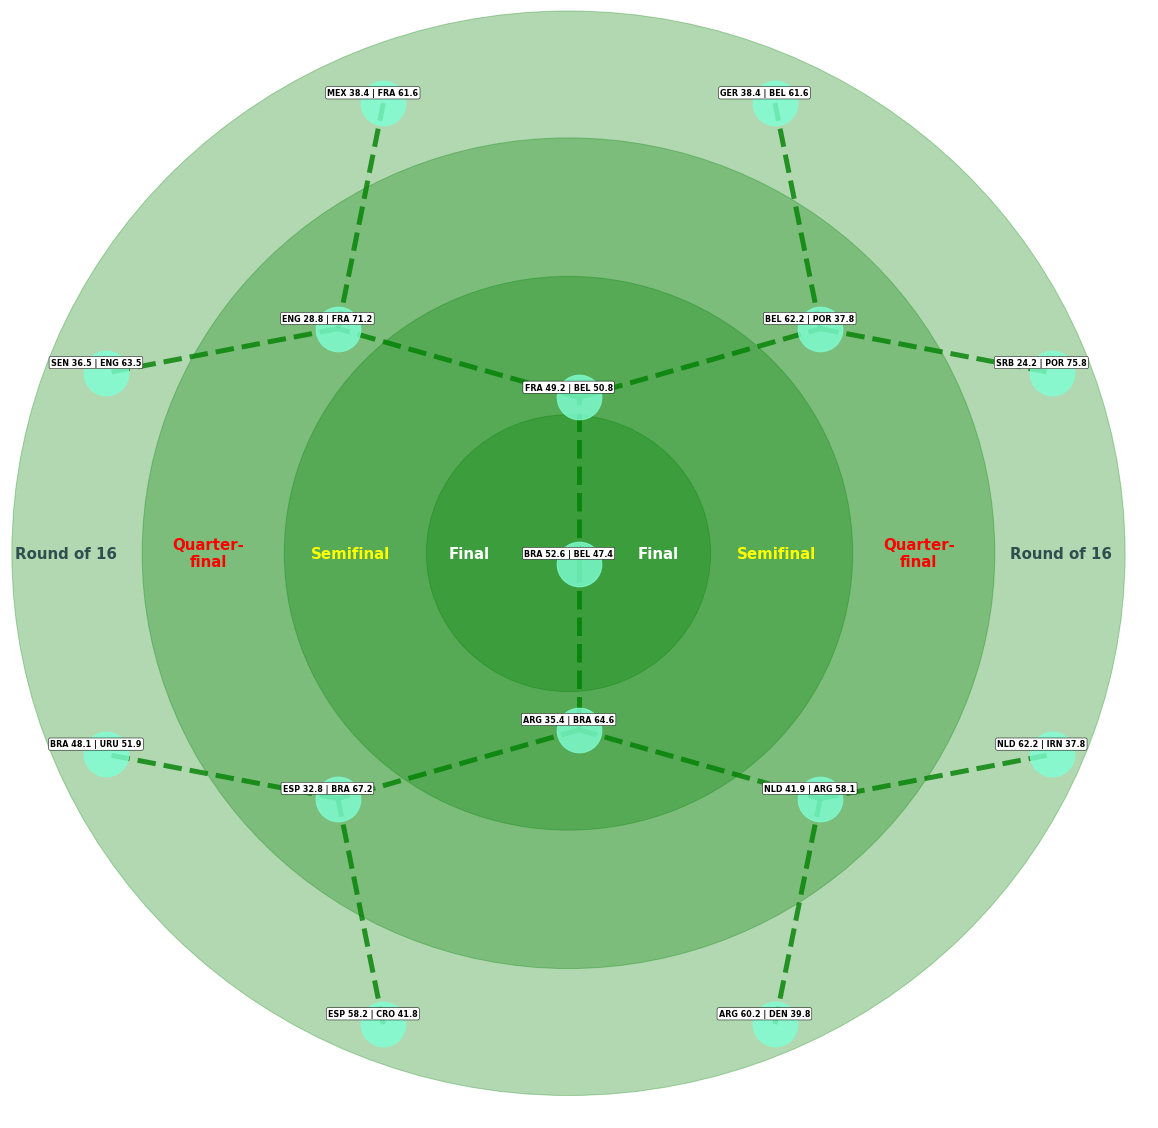

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt 
import random
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
#number_of_colors = 15

#color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
            # for i in range(number_of_colors)]
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(20.5, 20.5))
ax = plt.subplot(1,1,1)
# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='green', 
                          alpha=0.3)) for cp, c in circle_positions]
labels_pos = {k:[(v[0]-0.02*centre),v[1]+0.02*centre] for k,v in pos.items()}

# draw first the graph
nx.draw(G, pos, 
        node_color='aquamarine',
        node_size=2000, 
        alpha=0.8, 
        cmap=plt.cm.Greens,
        edge_color='green',
        width=5,
        style='dashed',
        with_labels=False)

# draw the custom node labels
nx.draw_networkx_labels(G, 
                        pos=labels_pos, 
                        font_color='black',
                        font_weight = 'bold',
                        font_size = 8, verticalalignment = 'center', bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(r16)-1)), labels)))

texts = ((10, 'Round of 16', 'darkslategrey'), (70, 'Quarter-\nfinal', 'red'), (130, 'Semifinal', 'yellow'), (180, 'Final', 'white'),(430, 'Round of 16', 'darkslategrey'), (370, 'Quarter-\nfinal', 'red'), (310, 'Semifinal', 'yellow'), (260, 'Final', 'white') )
[plt.text(p, centre, t, 
          fontsize=15, color=c, fontweight = 'bold', 
          va='center', ha='center') for p,t,c in texts]
#plt.title('FIFA World Cup Qatar 2022 Prediction - Monte Carlo Simulation ({} runs)'.format(runs), fontsize=20, x = 0.5, y = 1)
plt.savefig('FIFA Prediction_0712.png')
plt.show()

In [79]:
'''Attempt at creating xg analysis feature'''
masterdata.fillna(0, inplace = True)
home_wins = []
home_wins_goals =[]
home_draws = []
home_draws_goals = []
home_losses = []
home_losses_goals = []
away_wins = []
away_wins_goals =[]
away_draws = []
away_draws_goals = []
away_losses = []
away_losses_goals = []
index = []
index2 = []
for j,i in enumerate(masterdata.home_team.unique()):
    index.append(i)
    home = masterdata[masterdata.home_team == i]
    homewins = home[home.Result.isin([2])]
    homedraws = home[home.Result.isin([1])]
    homelosses = home[home.Result.isin([0])]
    home_wins.append(round(homewins.goal_fraction.sum()/(len(homewins)),2))
    home_wins_goals.append(round(homewins.home_score.astype(int).sum()/(len(homewins)),2))
    home_draws.append(round(homedraws.goal_fraction.sum()/(len(homedraws)),2))
    home_draws_goals.append(round(homedraws.home_score.astype(int).sum()/(len(homewins)),2))
    home_losses.append(round(homelosses.goal_fraction.sum()/(len(homelosses)),2))
    home_losses_goals.append(round(homelosses.home_score.astype(int).sum()/(len(homewins)),2))
    
for j,i in enumerate(masterdata.away_team.unique()):
    index2.append(i)
    away = masterdata[masterdata.away_team == i]
    awaywins = away[away.Result.isin([0])]
    awaydraws = away[away.Result.isin([1])]
    awaylosses = away[away.Result.isin([2])]
    away_wins.append(round((1-awaywins.goal_fraction).sum()/(len(awaywins)),2))
    away_wins_goals.append(round(awaywins.away_score.astype(int).sum()/(len(awaywins)),2))
    away_draws.append(round((1-awaydraws.goal_fraction).sum()/(len(awaydraws)),2))
    away_draws_goals.append(round(awaydraws.away_score.astype(int).sum()/(len(awaydraws)),2))
    away_losses.append(round((1-awaylosses.goal_fraction).sum()/(len(awaylosses)),2))
    away_losses_goals.append(round(awaylosses.away_score.astype(int).sum()/(len(awaylosses)),2))

home_results = pd.DataFrame(index = index)
home_results.insert(0, 'home_wins', home_wins)
home_results.insert(0, 'home_draws', home_draws)
home_results.insert(0, 'home_losses', home_losses)
home_results.insert(0, 'home_wins_goals', home_wins_goals)
home_results.insert(0, 'home_draws_goals', home_draws_goals)
home_results.insert(0, 'home_losses_goals', home_losses_goals)
away_results = pd.DataFrame(index = index2)
away_results.insert(0, 'away_wins', away_wins)
away_results.insert(0, 'away_draws', away_draws)
away_results.insert(0, 'away_losses', away_losses)
away_results.insert(0, 'away_wins_goals', away_wins_goals)
away_results.insert(0, 'away_draws_goals', away_draws_goals)
away_results.insert(0, 'away_losses_goals', away_losses_goals)
xgall = home_results.join(away_results)
xgall.fillna(0, inplace = True)
xgall = xgall[xgall.index.isin(wcteams)]
xgall  = xgall.assign(winperc = lambda xgall: (xgall.home_wins + xgall.away_wins)/2)
xgall = xgall.assign(drawsperc = lambda xgall: (xgall.home_draws + xgall.away_draws)/2)
xgall = xgall.assign(lossperc = lambda xgall: (xgall.home_losses + xgall.away_losses)/2)
xgall =xgall.assign(winxg = lambda xgall: (1 * ((xgall.home_wins_goals + xgall.away_wins_goals)/2)))
xgall =xgall.assign(drawxg = lambda xgall: (1* ((xgall.home_draws_goals + xgall.away_draws_goals)/2)))
xgall =xgall.assign(lossxg = lambda xgall: (1 * ((xgall.home_losses_goals + xgall.away_losses_goals)/2)))
xgall.head(10)

,home_losses_goals,home_draws_goals,home_wins_goals,home_losses,home_draws,home_wins,away_losses_goals,away_draws_goals,away_wins_goals,away_losses,away_draws,away_wins,winperc,drawsperc,lossperc,winxg,drawxg,lossxg
Ghana,0.25,0.50,1.92,0.12,0.36,0.88,0.27,0.70,1.67,0.07,0.75,0.89,0.885,0.555,0.095,1.795,0.600,0.260
Tunisia,1.17,1.67,1.33,0.18,0.32,0.89,0.56,0.80,1.70,0.12,0.70,0.90,0.895,0.510,0.150,1.515,1.235,0.865
Japan,0.40,0.57,2.17,0.15,0.26,0.92,0.69,0.88,2.50,0.16,0.69,0.87,0.895,0.475,0.155,2.335,0.725,0.545
Cameroon,0.27,0.82,1.91,0.12,0.30,0.92,0.64,0.73,2.00,0.13,0.68,0.85,0.885,0.490,0.125,1.955,0.775,0.455
Mexico,0.19,0.31,2.22,0.17,0.28,0.87,0.61,0.79,2.04,0.16,0.75,0.88,0.875,0.515,0.165,2.130,0.550,0.400
Costa Rica,0.28,0.61,2.22,0.11,0.31,0.87,0.29,0.75,2.00,0.07,0.75,0.82,0.845,0.530,0.090,2.110,0.680,0.285
Canada,0.11,0.33,1.89,0.06,0.17,0.90,0.29,0.88,1.75,0.09,0.69,0.83,0.865,0.430,0.075,1.820,0.605,0.200
United States,0.25,0.28,2.15,0.15,0.31,0.90,0.43,0.75,2.50,0.12,0.62,0.88,0.890,0.465,0.135,2.325,0.515,0.340
South Korea,0.83,0.58,1.83,0.17,0.27,0.88,0.62,0.86,2.62,0.17,0.64,0.84,0.860,0.455,0.170,2.225,0.720,0.725
Argentina,0.02,0.27,2.58,0.02,0.32,0.89,0.53,0.86,2.41,0.12,0.68,0.87,0.880,0.500,0.070,2.495,0.565,0.275


In [80]:
xgall = xgall[xgall.columns[-3:]]
xgall.sort_values(by = 'winxg', ascending = False).head(10)

,winxg,drawxg,lossxg
Netherlands,2.800,0.520,0.400
Brazil,2.795,0.475,0.195
Qatar,2.750,1.625,2.550
Germany,2.700,1.000,0.170
Argentina,2.495,0.565,0.275
Spain,2.480,0.645,0.440
Belgium,2.470,0.700,0.305
Australia,2.460,0.580,0.620
England,2.420,0.610,0.430
Japan,2.335,0.725,0.545


In [81]:
def xgh2h (P1, P2, masterdata):
    values = [(P1 + P2), (P2 + P1)]
    #xgp1 = []
    #xgp2 = []
    for i in range(len(masterdata)): 
        if masterdata.concat.iloc[i] == P1 + P2 or masterdata.concat.iloc[i] == P2 + P1: 
            masterdata = masterdata[masterdata.concat.isin(values)]
            h1 = masterdata[masterdata.home_team == P1].home_score.astype(int).sum()
            h2 = masterdata[masterdata.away_team == P2].away_score.astype(int).sum()
            a2 = masterdata[masterdata.home_team == P2].home_score.astype(int).sum()
            a1 = masterdata[masterdata.away_team == P1].away_score.astype(int).sum()
            p1xg = (h1+a1)/(len(masterdata[masterdata.concat == P1 + P2]) + len(masterdata[masterdata.concat == P1 + P2]))
            p2xg = (h2+a2)/(len(masterdata[masterdata.concat == P1 + P2]) + len(masterdata[masterdata.concat == P1 + P2]))
            return p1xg, p2xg
        else:
            pass
    return 0,0
            

In [82]:
xgh2h('England', 'Qatar', masterdata)

(0, 0)

In [83]:
xgall.loc['England'][0], xgall.loc['Qatar'][0]

(2.42, 2.75)